In [1]:
"""
This script processes flight data using PySpark and GraphFrames. It performs the following tasks:

1. Loads flight data from a CSV file and checks for null values.
2. Cleans and preprocesses the data (casts columns, handles outliers, etc.).
3. Builds graphs using GraphFrames to represent networks.
4. Computes PageRank on the graphs to find relevant information.
5. Visualizes the flight network using NetworkX and matplotlib, including edge weights for prices and node sizes based on PageRank.
6. Analyzes average prices by airline, computes price differences between airlines, and visualizes the results.
7. Calculates degree centrality to analyze the number of connections for each city.

The script uses Spark for distributed computation and GraphFrames for graph analytics.
"""
#Checking the installed Java version
!java -version
%pip install "pyspark==3.5.0"
# Install Java 17
!sudo apt-get update
!sudo apt-get install -y openjdk-17-jdk-headless

!java -version

openjdk version "17.0.14-internal" 2025-01-21
OpenJDK Runtime Environment (build 17.0.14-internal+0-adhoc..src)
OpenJDK 64-Bit Server VM (build 17.0.14-internal+0-adhoc..src, mixed mode, sharing)
Note: you may need to restart the kernel to use updated packages.
Hit:1 https://packages.cloud.google.com/apt cloud-sdk InRelease
Get:2 https://nvidia.github.io/libnvidia-container/stable/deb/amd64  InRelease [1477 B]
Hit:3 https://cli.github.com/packages stable InRelease                         
Hit:4 https://download.docker.com/linux/ubuntu noble InRelease                 
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64  InRelease
Hit:6 https://security.ubuntu.com/ubuntu noble-security InRelease              
Hit:7 https://us-east-1.ec2.archive.ubuntu.com/ubuntu noble InRelease          
Hit:8 https://us-east-1.ec2.archive.ubuntu.com/ubuntu noble-updates InRelease  
Hit:9 https://us-east-1.ec2.archive.ubuntu.com/ubuntu noble-backports InRelease
Hit:10 http://

In [2]:
%pip install graphframes-py==0.10.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Set JAVA_HOME to Java 17
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
from pyspark.sql import SparkSession

#spark = SparkSession.builder \
    #.appName("GraphFramesWithSpark4") \
    #.config("spark.jars.packages", "io.graphframes:graphframes-spark3_2.12:0.10.0") \
    #.getOrCreate()

spark = SparkSession.builder \
    .appName("GraphFramesWithOptimization") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.1-s_2.12") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

print(f"spark version: {spark.version}")
print("spark session created with graphframes package specified!")

:: loading settings :: url = jar:file:/system/conda/miniconda3/envs/cloudspace/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/zeus/.ivy2/cache
The jars for the packages stored in: /home/zeus/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c9543205-2287-4dd8-8e21-803c859dabb7;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.1-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 308ms :: artifacts dl 13ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.1-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	------------------------------------

spark version: 3.5.0
spark session created with graphframes package specified!


In [4]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, ArrayType, IntegerType, NumericType
)

In [5]:
#import the package we just installed
from graphframes import *
#import data types - All data types of Spark SQL are located in the package of pyspark.sql.types
from pyspark.sql.types import *
#row can be used to create a row object by using named arguments
from pyspark.sql import Row
from pyspark.sql.functions import col, when, sum
#creating checkpoint directory
direc_cp = "/teamspace/studios/this_studio/graphframes"
spark.sparkContext.setCheckpointDir(direc_cp)


In [6]:
"""
Load flight data, check for null values, and clean the dataset
"""
df = spark.read.option("header", "true").option('inferSchema', 'true').csv("/teamspace/studios/this_studio/graphframes/airlines_flights_data.csv")

In [7]:
df.show(10)

+-----+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|index| airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+-----+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|    0|SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
|    1|SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|    2| AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|    3| Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|    4| Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5955|
|    5| Vistara| UK-945|

In [8]:
df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- flight: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- price: integer (nullable = true)



In [9]:
#checking for null values
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+-----+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+
|index|airline|flight|source_city|departure_time|stops|arrival_time|destination_city|class|duration|days_left|price|
+-----+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+
|    0|      0|     0|          0|             0|    0|           0|               0|    0|       0|        0|    0|
+-----+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+



In [10]:
#correct data types
df_cleaned = df.withColumn("price", col("price").cast("double"))

In [11]:
df_cleaned.show(5)

+-----+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+------+
|index| airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left| price|
+-----+--------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+------+
|    0|SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1|5953.0|
|    1|SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1|5953.0|
|    2| AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1|5956.0|
|    3| Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1|5955.0|
|    4| Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1|5955.0|
+-----+--------+

In [12]:
df_cleaned.groupBy("stops").count().show()

+-----------+------+
|      stops| count|
+-----------+------+
|two_or_more| 13286|
|        one|250863|
|       zero| 36004|
+-----------+------+



In [13]:
#replacing words to numerical
df_cleaned = df_cleaned.withColumn("stops",
                                   when(col("stops") == "zero", 0)
                                   .when(col("stops") == "one", 1)
                                   .when(col("stops") == "two_or_more", 2))


In [14]:
#handling inconsistencies
df_cleaned = df_cleaned.filter((col("duration") >= 0) & (col("duration") <= 48))  #realistic duration

In [37]:
df_cleaned_cp = df_cleaned.repartition(128)
df_cleaned_cp = df_cleaned_cp.checkpoint()

In [38]:
df_cleaned_cp.show(10)

+-----+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-------+
|index|  airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|  price|
+-----+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-------+
|  945| GO_FIRST| G8-323|      Delhi|       Evening|    0|        Night|          Mumbai|Economy|    2.33|        7| 5954.0|
|10831|Air_India| AI-542|      Delhi|       Morning|    1|        Night|       Bangalore|Economy|    12.0|        6|10208.0|
|25942|  Vistara| UK-963|      Delhi|       Morning|    1|      Evening|         Kolkata|Economy|     8.0|       34| 6578.0|
|16762|  Vistara| UK-993|      Delhi|     Afternoon|    1|        Night|       Bangalore|Economy|    8.08|       34| 4496.0|
|29423|  Vistara| UK-801|      Delhi|       Morning|    1|        Night|       Hyderabad|Economy|   11.83|        7|11310.0|


In [39]:
departure_cities = df_cleaned_cp.select("source_city").distinct().withColumnRenamed("source_city", "id")
destination_cities = df_cleaned_cp.select("destination_city").distinct().withColumnRenamed("destination_city", "id")
departure_cities.show()
destination_cities.show()

+---------+
|       id|
+---------+
|Bangalore|
|  Chennai|
|   Mumbai|
|  Kolkata|
|    Delhi|
|Hyderabad|
+---------+

+---------+
|       id|
+---------+
|Bangalore|
|  Chennai|
|   Mumbai|
|  Kolkata|
|    Delhi|
|Hyderabad|
+---------+



In [40]:
"""
GraphFrame Creation and PageRank Calculation
- Build a graph of flight routes with cities as vertices and airlines as edges.
- Use PageRank to find important cities and airlines.
"""
#cities, airlines and prices graphframe
#vertices for cities (departure and destination)
departure_cities = df_cleaned_cp.select("source_city").distinct().withColumnRenamed("source_city", "id")
destination_cities = df_cleaned_cp.select("destination_city").distinct().withColumnRenamed("destination_city", "id")

#vertices will be all cities (departure and destination)
gf_vertices = departure_cities.union(destination_cities).distinct()

print(f"Total cities (vertices): {gf_vertices.count()}")

#edges will be flights with airline and price as attributes
gf_edges = df_cleaned_cp.select(
    col("source_city").alias("src"),
    col("destination_city").alias("dst"),
    "airline",
    "price").distinct()

#partitioning edges for graph performance
gf_edges = gf_edges.repartition(128, "src", "dst")
gf_vertices.cache()
gf_edges.cache()

print(f"Total routes (edges): {gf_edges.count()}")

graph_airlines_prices = GraphFrame(gf_vertices, gf_edges)

Total cities (vertices): 6


Total routes (edges): 21476


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [41]:
#pagerank to find important cities and airlines based on their connections
pagerank_result = graph_airlines_prices.pageRank(resetProbability=0.15, maxIter=10)
pagerank_result.vertices.select("id", "pagerank").orderBy("pagerank", ascending=False).show(10)


+---------+------------------+
|       id|          pagerank|
+---------+------------------+
|   Mumbai|1.2064553217077976|
|    Delhi| 1.117904717501588|
|  Kolkata|1.0772868357906995|
|Bangalore|0.9168660268952435|
|Hyderabad|0.8420512852729001|
|  Chennai|0.8394358128317713|
+---------+------------------+



/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


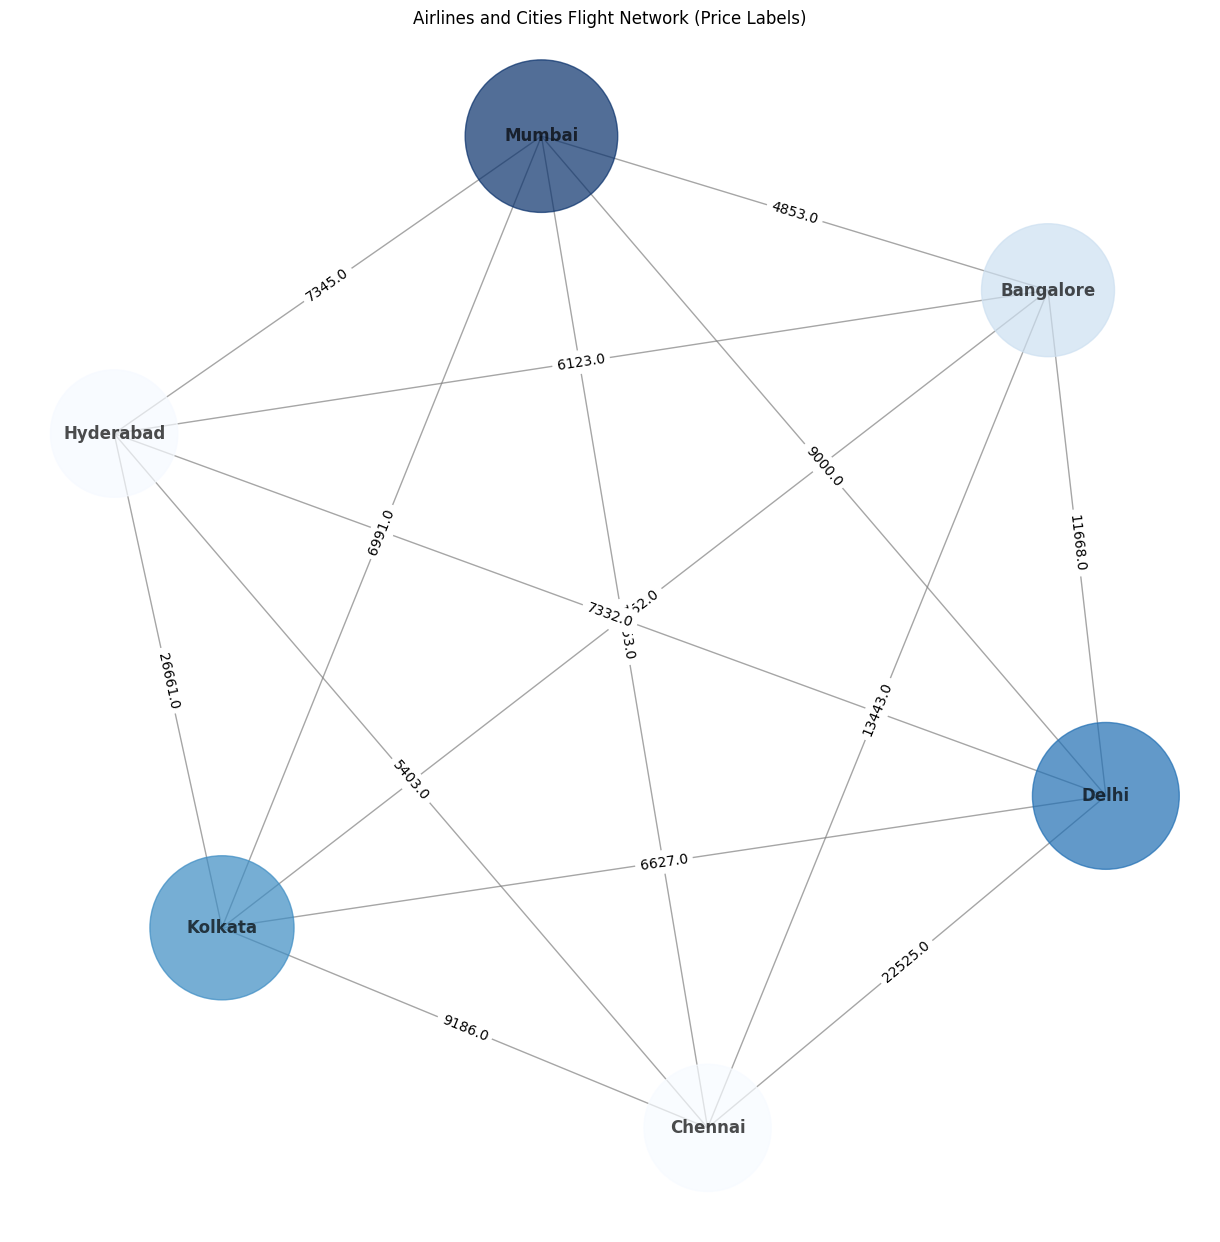

In [42]:
"""
NetworkX Graph Construction and Visualization
- Convert the GraphFrame to RDDs and use NetworkX for graph visualization.
- Visualize the flight network with nodes representing cities and edges representing flight routes.
"""
#converting graphframe to RDDs
edges_rdd = graph_airlines_prices.edges.rdd
vertices_rdd = graph_airlines_prices.vertices.rdd

#creating a graph
G = nx.Graph()

#adding nodes for cities (departure and destination)
for row in vertices_rdd.collect():
    G.add_node(row['id'])

#adding edges with airline and price as attributes
for row in edges_rdd.collect():
    G.add_edge(row['src'], row['dst'], airline=row['airline'], price=row['price'])

#positioning nodes using spring layout (force-directed layout)
pos = nx.spring_layout(G, k=0.5)

#size of nodes based on pagerank values (if available)
pagerank_dict = {row['id']: row['pagerank'] for row in pagerank_result.vertices.collect()}
node_sizes = [pagerank_dict[node] * 10000 for node in G.nodes()]

#color nodes based on pagerank values (darker colors for higher values)
node_colors = [pagerank_dict[node] for node in G.nodes()]

#visualizing the network graph
plt.figure(figsize=(12, 12))

#drawing nodes, edges, and labels
nx.draw(G, pos, with_labels=True, node_size=node_sizes, font_size=12, font_weight='bold',
        node_color=node_colors, cmap=plt.cm.Blues, edge_color="gray", linewidths=1, alpha=0.7)

#drawing edge labels with prices
edge_labels = nx.get_edge_attributes(G, 'price')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='black')

#show the plot
plt.title("Airlines and Cities Flight Network (Price Labels)")
plt.axis('off')
plt.show()

In [43]:
"""
Price Analysis
- Calculate the average price for each airline and visualize price differences between airlines.
"""
#calculating average price for each airline
average_prices = graph_airlines_prices.edges.groupBy("airline").agg(F.avg("price").alias("avg_price"))
average_prices.show()

#price difference calculation with broadcast to optimize crossjoin
average_prices_broadcast = average_prices.select("airline", "avg_price").rdd \
    .map(lambda x: (x['airline'], x['avg_price'])).collectAsMap()

broadcasted_prices = spark.sparkContext.broadcast(average_prices_broadcast)

price_diff = average_prices.alias("a").crossJoin(average_prices.alias("b")) \
    .filter(F.col("a.airline") < F.col("b.airline")) \
    .select(F.col("a.airline").alias("airline1"), F.col("b.airline").alias("airline2"),
            (F.abs(F.col("a.avg_price") - F.col("b.avg_price"))).alias("price_difference"))

price_diff.show()

+---------+------------------+
|  airline|         avg_price|
+---------+------------------+
|   Indigo|  8843.91246470351|
| SpiceJet| 9230.846091205212|
|Air_India|14926.963198546115|
|  AirAsia| 8787.304283604137|
| GO_FIRST| 8899.644666666667|
|  Vistara| 29130.87941628264|
+---------+------------------+



+---------+---------+------------------+
| airline1| airline2|  price_difference|
+---------+---------+------------------+
|Air_India|   Indigo| 6083.050733842605|
|  AirAsia|   Indigo|56.608181099372814|
| GO_FIRST|   Indigo| 55.73220196315742|
|   Indigo| SpiceJet|386.93362650170275|
|Air_India| SpiceJet| 5696.117107340902|
|  AirAsia| SpiceJet|443.54180760107556|
| GO_FIRST| SpiceJet| 331.2014245385453|
|  AirAsia|Air_India| 6139.658914941978|
|Air_India| GO_FIRST| 6027.318531879448|
|  AirAsia| GO_FIRST|112.34038306253024|
|   Indigo|  Vistara|20286.966951579132|
| SpiceJet|  Vistara|19900.033325077427|
|Air_India|  Vistara|14203.916217736527|
|  AirAsia|  Vistara|20343.575132678503|
| GO_FIRST|  Vistara|20231.234749615975|
+---------+---------+------------------+



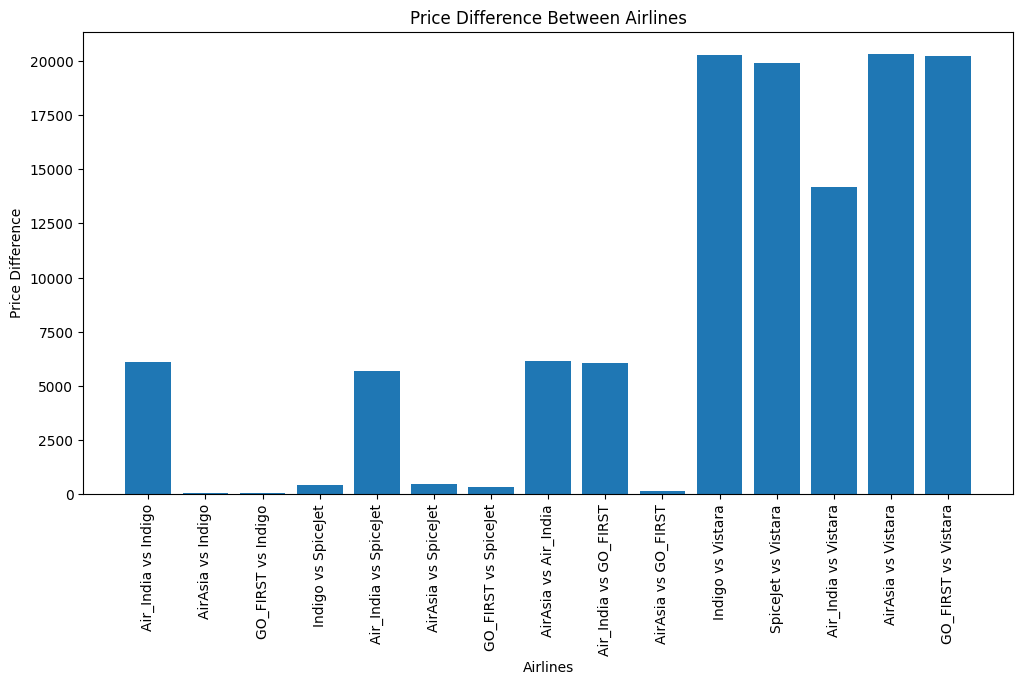

In [44]:
#visualization of price differences between airlines
#limiting the price_diff dataframe to a manageable size for visualization (100 rows to avoid memory overload)
price_diff_limited = price_diff.limit(100)

#collecting the limited data
price_diff_data = price_diff_limited.collect()

#extracting the airline names and price differences into lists
airline1 = [row['airline1'] for row in price_diff_data]
airline2 = [row['airline2'] for row in price_diff_data]
price_diff_values = [row['price_difference'] for row in price_diff_data]

#visualize the price differences between airlines
plt.figure(figsize=(12, 6))
plt.bar([f"{a1} vs {a2}" for a1, a2 in zip(airline1, airline2)], price_diff_values)
plt.xticks(rotation=90)
plt.xlabel("Airlines")
plt.ylabel("Price Difference")
plt.title("Price Difference Between Airlines")
plt.show()

In [45]:
"""
Degree Centrality and Visualization
- Calculate the degree centrality (number of connections) for each city/airline.
- Visualize the degree centrality for cities in the flight network.
"""
#degree centrality (number of connections) for each vertex (city or airline)
degree = graph_airlines_prices.degrees
degree.show()

+---------+------+
|       id|degree|
+---------+------+
|  Chennai|  5991|
|    Delhi|  8344|
|   Mumbai|  8884|
|Bangalore|  6562|
|  Kolkata|  7539|
|Hyderabad|  5632|
+---------+------+



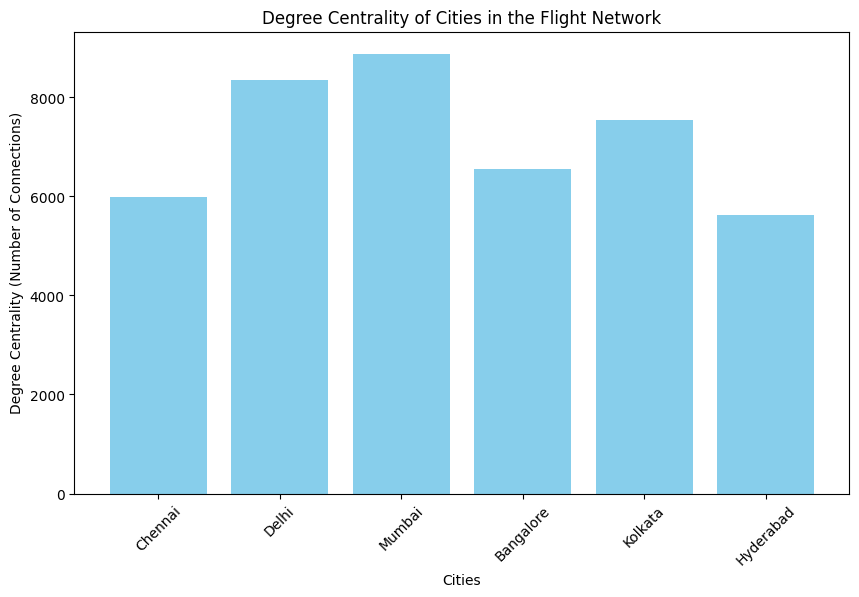

In [46]:
#visualization for degree centrality
#limiting the number of rows to a manageable size
degree_limited = degree.limit(100)

#collecting the limited degree centrality data
degree_data = degree_limited.collect()

#extracting the degree centrality values into lists for plotting
ids = [row['id'] for row in degree_data]
degree_values = [row['degree'] for row in degree_data]

#visualize the degree centrality
plt.figure(figsize=(10, 6))
plt.bar(ids, degree_values, color='skyblue')
plt.xlabel('Cities')
plt.ylabel('Degree Centrality (Number of Connections)')
plt.title('Degree Centrality of Cities in the Flight Network')
plt.xticks(rotation=45)
plt.show()

In [47]:
"""
GraphFrame Creation and PageRank Calculation
- Build a graph with departure and arrival times as vertices and flight prices and classes as edges.
- Use PageRank to find relevant times of day.
"""
#time of day, price and class graphframe
#defining price buckets based on ranges
df_cleaned_cp = df_cleaned_cp.withColumn(
    "price_bucket",
    F.when(F.col("price") < 2000, "Low")
    .when((F.col("price") >= 2000) & (F.col("price") < 5000), "Medium")
    .when(F.col("price") >= 5000, "High")
    .otherwise("Unknown"))

#check
df_cleaned_cp.select("price", "price_bucket").show(10)

+-------+------------+
|  price|price_bucket|
+-------+------------+
| 5954.0|        High|
|10208.0|        High|
| 6578.0|        High|
| 4496.0|      Medium|
|11310.0|        High|
| 5943.0|        High|
| 5772.0|        High|
| 5954.0|        High|
| 6173.0|        High|
| 2098.0|      Medium|
+-------+------------+
only showing top 10 rows



In [48]:
#defining weight for each class
df_cleaned_cp = df_cleaned_cp.withColumn(
    "class_weight",
    F.when(F.col("class") == "Economy", 1)
    .when(F.col("class") == "Business", 2)
    .when(F.col("class") == "First Class", 3)
    .otherwise(0))

#check
df_cleaned_cp.select("class", "class_weight").show(10)

+-------+------------+
|  class|class_weight|
+-------+------------+
|Economy|           1|
|Economy|           1|
|Economy|           1|
|Economy|           1|
|Economy|           1|
|Economy|           1|
|Economy|           1|
|Economy|           1|
|Economy|           1|
|Economy|           1|
+-------+------------+
only showing top 10 rows



In [49]:
"""
Creating vertices for departure and arrival times.
These will be used as nodes in the graph.
"""
#creating vertices for departure and arrival times
departure_times = df_cleaned_cp.select("departure_time").distinct().withColumnRenamed("departure_time", "id")
arrival_times = df_cleaned_cp.select("arrival_time").distinct().withColumnRenamed("arrival_time", "id")
times = departure_times.union(arrival_times).distinct()
times.cache()

"""
Aggregating flight data by departure and arrival times, including price bucket and class weight.
This will form the edges of the graph, representing connections between times.
"""
#aggregating prices by departure and arrival time and including price bucket and class weight
edges_timeprice_weighted = df_cleaned_cp.groupBy("departure_time", "arrival_time", "price_bucket", "class_weight") \
                                     .agg(F.avg("price").alias("avg_price")) \
                                     .withColumnRenamed("departure_time", "src") \
                                     .withColumnRenamed("arrival_time", "dst")
edges_timeprice_weighted.cache()

time_graph_weighted = GraphFrame(times, edges_timeprice_weighted)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


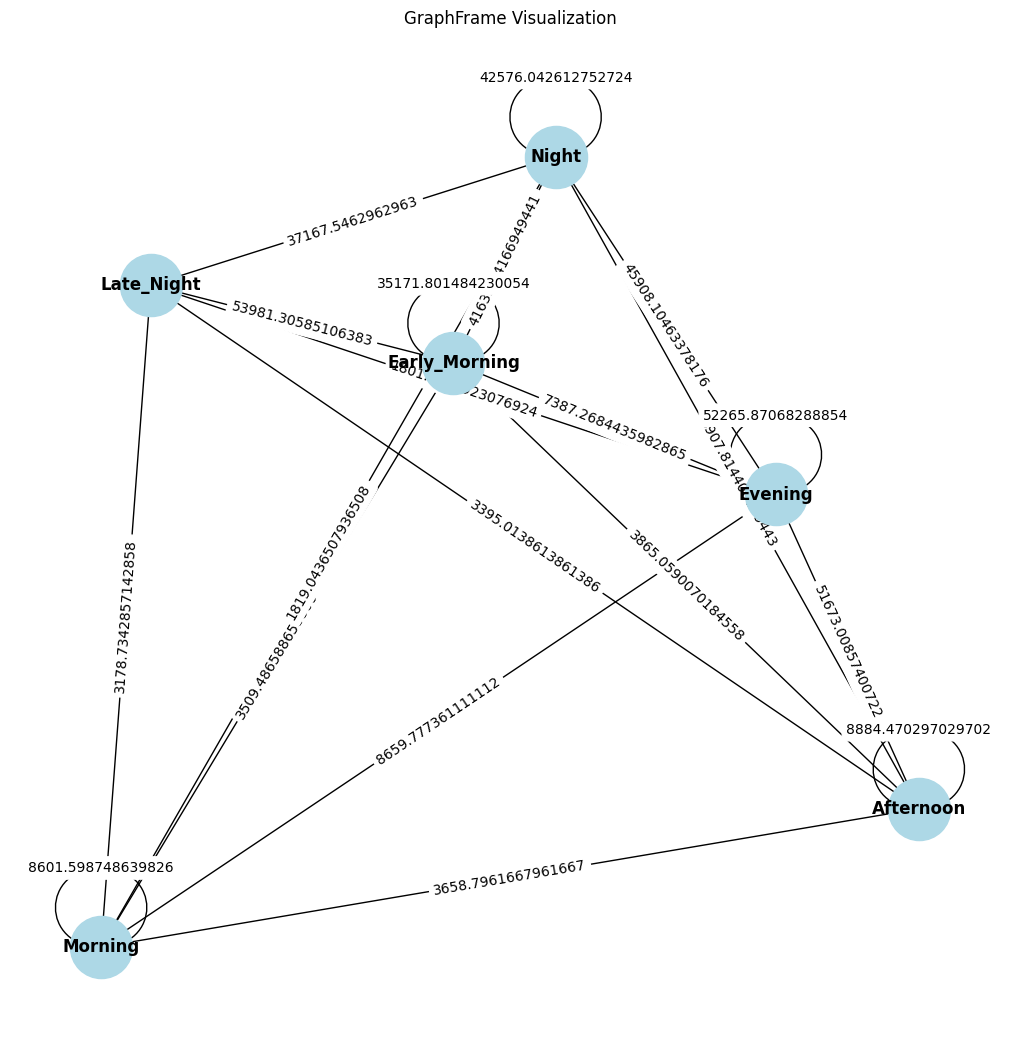

In [50]:
"""
GraphFrame to a graph for visualization: We limit the edges to a manageable size for visualization.
"""
#graphframe to a graph
#limiting the edges to a manageable size for visualization
edges_timeprice_weighted_limited = edges_timeprice_weighted.limit(100)

#collecting the limited edges data
edges_data = edges_timeprice_weighted_limited.collect()

#creating a graph
G_priceclass = nx.Graph()

#adding nodes for departure and arrival times (vertices)
for row in edges_data:
    G_priceclass.add_node(row['src'])
    G_priceclass.add_node(row['dst'])

#adding edges with weights (avg_price) in the graph
for row in edges_data:
    G_priceclass.add_edge(row['src'], row['dst'], weight=row['avg_price'])

#positioning of nodes using spring layout (force-directed layout)
pos2 = nx.spring_layout(G_priceclass)  # Positioning of nodes

#plot the graph with labels and edge weights
plt.figure(figsize=(10, 10))
nx.draw(G_priceclass, pos2, with_labels=True, node_size=2000, font_size=12, node_color='lightblue', font_weight='bold')
edge_labels2 = nx.get_edge_attributes(G_priceclass, 'weight')
nx.draw_networkx_edge_labels(G_priceclass, pos2, edge_labels=edge_labels2)

plt.title("GraphFrame Visualization")
plt.show()

In [51]:
"""
PageRank Calculation and Visualization:
- Compute PageRank for the weighted graph and visualize the result based on time of day.
"""
#pagerank with weighted graph
pagerank_result_weighted = time_graph_weighted.pageRank(resetProbability=0.15, maxIter=20)
pagerank_result_weighted.vertices.select("id", "pagerank").orderBy("pagerank", ascending=False).show()

+-------------+------------------+
|           id|          pagerank|
+-------------+------------------+
|        Night|1.0686007181748827|
|      Morning|1.0303044458376496|
|    Afternoon|0.9911976369636797|
|Early_Morning|0.9904972286121042|
|      Evening| 0.977262837034749|
|   Late_Night|0.9421371333769359|
+-------------+------------------+



/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


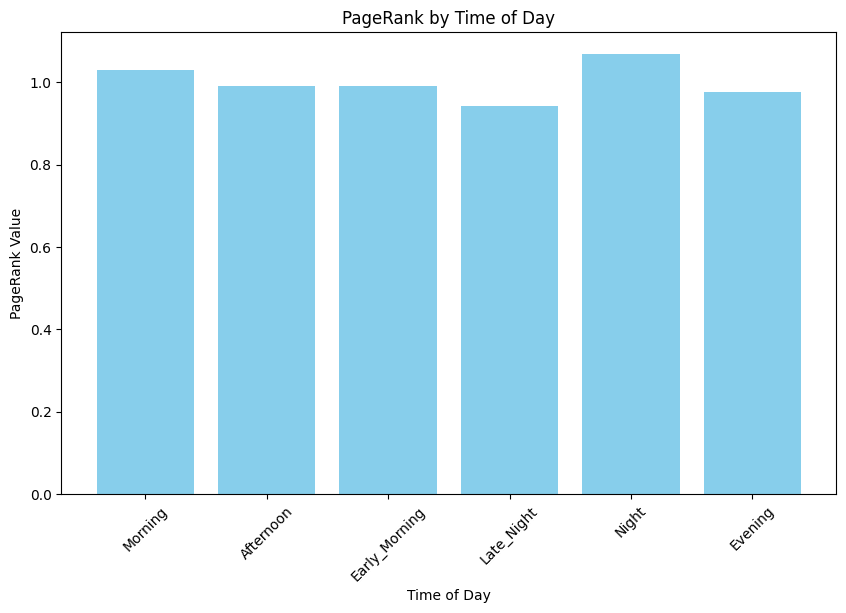

In [52]:
#collecting a limited sample for visualization
pagerank_limited = pagerank_result_weighted.vertices.limit(100)
pagerank_data = pagerank_limited.collect()

#extracting data for plotting
pagerank_ids = [row['id'] for row in pagerank_data]
pagerank_values = [row['pagerank'] for row in pagerank_data]

#plot the pagerank values by time of day
plt.figure(figsize=(10, 6))
plt.bar(pagerank_ids, pagerank_values, color='skyblue')
plt.xlabel('Time of Day')
plt.ylabel('PageRank Value')
plt.title('PageRank by Time of Day')
plt.xticks(rotation=45)
plt.show()

In [53]:
"""
Motif Detection and Visualization:
- Find motifs where times with high prices are connected and visualize them.
"""
#using motif to find patterns where times with high prices are connected
#find motif structure
motifs_weighted = time_graph_weighted.find("(a)-[e]->(b); (b)-[e2]->(c)")

#applying a filter
motifs_filtered = motifs_weighted.filter("e.avg_price > 5000")
motifs_filtered.show()

+---------------+--------------------+-------+--------------------+---------------+
|              a|                   e|      b|                  e2|              c|
+---------------+--------------------+-------+--------------------+---------------+
|{Early_Morning}|{Early_Morning, N...|{Night}|{Night, Early_Mor...|{Early_Morning}|
|{Early_Morning}|{Early_Morning, N...|{Night}|{Night, Morning, ...|      {Morning}|
|{Early_Morning}|{Early_Morning, N...|{Night}|{Night, Morning, ...|      {Morning}|
|{Early_Morning}|{Early_Morning, N...|{Night}|{Night, Morning, ...|      {Morning}|
|{Early_Morning}|{Early_Morning, N...|{Night}|{Night, Afternoon...|    {Afternoon}|
|{Early_Morning}|{Early_Morning, N...|{Night}|{Night, Morning, ...|      {Morning}|
|{Early_Morning}|{Early_Morning, N...|{Night}|{Night, Late_Nigh...|   {Late_Night}|
|{Early_Morning}|{Early_Morning, N...|{Night}|{Night, Afternoon...|    {Afternoon}|
|{Early_Morning}|{Early_Morning, N...|{Night}|{Night, Evening, ...|      {Ev

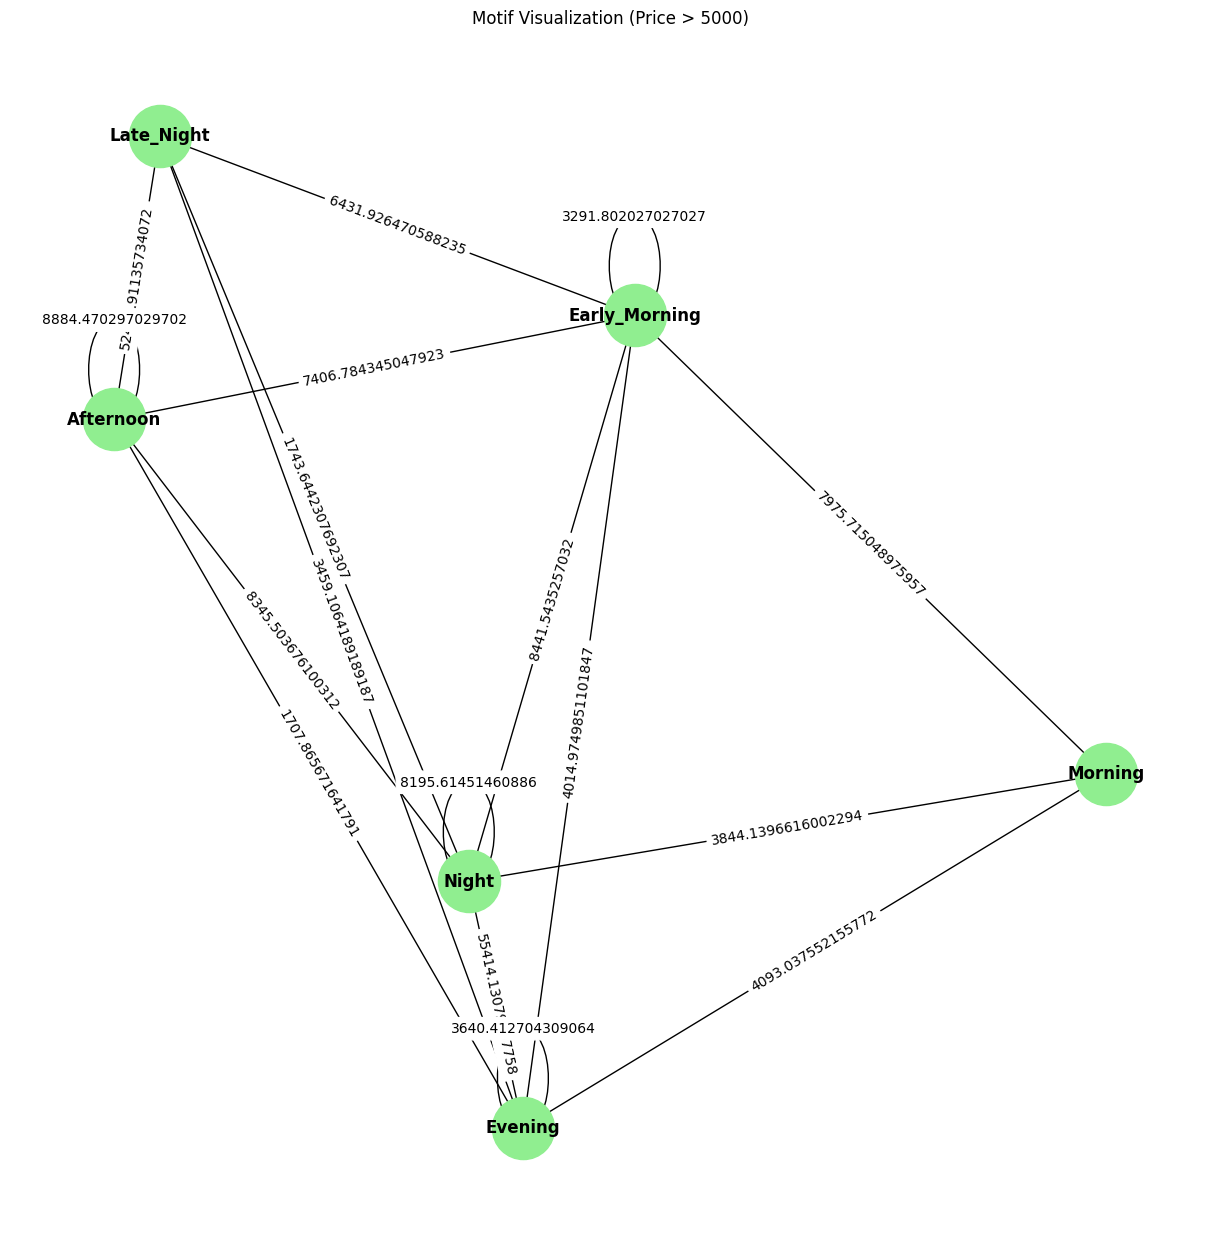

In [54]:
#collecting a manageable subset for visualization
motifs_filtered_limited = motifs_filtered.limit(100)
motifs_filtered_data = motifs_filtered_limited.collect()

#creating graph for motifs
motifs_G = nx.Graph()

#adding edges based on motifs (a, b, c) structure
for row in motifs_filtered_data:
    motifs_G.add_edge(row['a'][0], row['b'][0], weight=row['e'][4])
    motifs_G.add_edge(row['b'][0], row['c'][0], weight=row['e2'][4])

#plot the motif visualization
plt.figure(figsize=(12, 12))
pos3 = nx.spring_layout(motifs_G)
nx.draw(motifs_G, pos3, with_labels=True, node_size=2000, font_size=12, node_color='lightgreen', font_weight='bold')
edge_labels3 = nx.get_edge_attributes(motifs_G, 'weight')
nx.draw_networkx_edge_labels(motifs_G, pos3, edge_labels=edge_labels3)

plt.title('Motif Visualization (Price > 5000)')
plt.show()